In [5]:
# --- PART 0: SETUP AND LIBRARIES ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import chi2_contingency
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [6]:
cluster_data = pd.read_csv("cluster_data.csv")[['participant_id', 'cluster']]
MOCA_data = pd.read_csv("MOCA_cleaned.csv")

In [7]:
cluster_data_with_MOCA = cluster_data.merge(MOCA_data, on = "participant_id", how = "outer")
cluster_data_with_MOCA.head()

,participant_id,cluster,visit_month,moca_total_score
0,BF-1002,NaN,0.0,29.0
1,BF-1003,NaN,0.0,30.0
2,BF-1004,NaN,0.0,28.0
3,BF-1006,NaN,0.0,25.0
4,BF-1008,NaN,0.0,29.0


In [9]:
cluster_data_with_MOCA.isna().sum()

participant_id         0
cluster             1414
visit_month          110
moca_total_score     114
dtype: int64

In [12]:
cluster_data_with_MOCA.dropna(inplace = True)
cluster_data_with_MOCA['participant_id'].nunique()

1044

In [13]:
cluster_data_with_MOCA.head()

,participant_id,cluster,visit_month,moca_total_score
114,PD-PDAA503EF5,0.0,0.0,19.0
115,PD-PDAA503EF5,0.0,12.0,16.0
116,PD-PDAA503EF5,0.0,24.0,25.0
117,PD-PDAA503EF5,0.0,36.0,18.0
118,PD-PDAA503EF5,0.0,48.0,13.0


In [15]:
import statsmodels.formula.api as smf

# Load your data
df = cluster_data_with_MOCA.copy()

# Make sure datatypes are correct
df['cluster'] = df['cluster'].astype('category')
df['participant_id'] = df['participant_id'].astype('category')

# Fit linear mixed-effects model
# Random intercepts for each participant
model = smf.mixedlm("moca_total_score ~ cluster * visit_month", 
                    df, 
                    groups=df["participant_id"])
result = model.fit()

# Show summary
print(result.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   moca_total_score
No. Observations:     25499     Method:               REML            
No. Groups:           1044      Scale:                2.8548          
Min. group size:      3         Log-Likelihood:       -51739.5819     
Max. group size:      63        Converged:            Yes             
Mean group size:      24.4                                            
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                  25.775    0.148 173.835 0.000 25.484 26.065
cluster[T.1.0]              1.262    0.192   6.567 0.000  0.886  1.639
visit_month                -0.012    0.001 -14.932 0.000 -0.013 -0.010
cluster[T.1.0]:visit_month  0.009    0.001   8.683 0.000  0.007  0.011
Group Var              

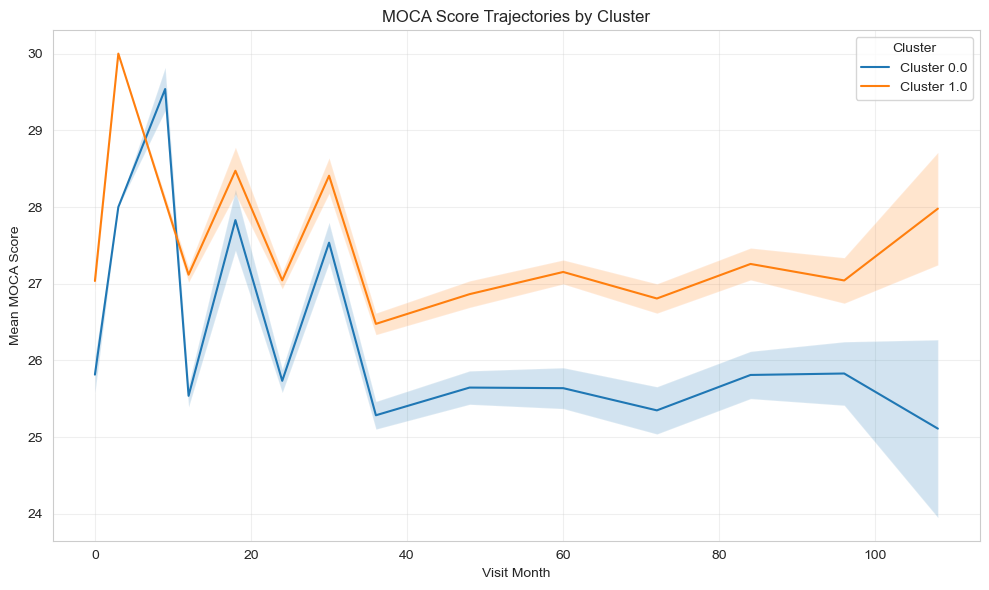

In [16]:
df['cluster'] = df['cluster'].astype(str)  # Ensure cluster is string for labeling

# Setup figure
plt.figure(figsize=(10, 6))

# Calculate and plot mean MOCA + 95% CI for each cluster
for cluster_id, cluster_data in df.groupby('cluster'):
    monthly_means = cluster_data.groupby('visit_month')['moca_total_score'].mean()
    monthly_std = cluster_data.groupby('visit_month')['moca_total_score'].std()
    monthly_count = cluster_data.groupby('visit_month')['moca_total_score'].count()
    
    # 95% confidence interval
    ci = 1.96 * monthly_std / np.sqrt(monthly_count)
    
    # Plot
    plt.plot(monthly_means.index, monthly_means.values, label=f'Cluster {cluster_id}')
    plt.fill_between(
        monthly_means.index,
        monthly_means.values - ci.values,
        monthly_means.values + ci.values,
        alpha=0.2
    )

# Final plot formatting
plt.title("MOCA Score Trajectories by Cluster")
plt.xlabel("Visit Month")
plt.ylabel("Mean MOCA Score")
plt.legend(title="Cluster")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

